## Ví dụ trên Python
Khai báo các thư viện cần dùng.

In [38]:
from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import random
np.random.seed(11)

Tạo dữ liệu bằng cách lấy các điểm theo phân phối chuẩn có kỳ vọng tại `(2, 2), (8, 3)` và `(3, 6)`, ma trận hiệp phương sai giống nhau và là ma trận đơn vị. Mỗi cụm có 500 điểm. Hiển thị các cụm điểm trên đồ thị.

In [39]:
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

X = np.concatenate((X0, X1, X2), axis = 0)
K = 3

original_label = np.asarray([0]*N + [1]*N + [2]*N).T

Viết hàm `kmeans_display` để hiển thị dữ liệu. Sau đó hiển thị dữ liệu theo nhãn ban đầu.

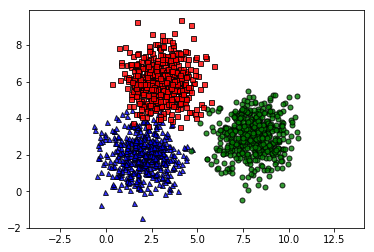

In [40]:
def kmeans_display(X, label):
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    
    kwargs = {"markersize": 5, "alpha": .8, "markeredgecolor": 'k'}
    plt.plot(X0[:, 0], X0[:, 1], 'b^', **kwargs)
    plt.plot(X1[:, 0], X1[:, 1], 'go', **kwargs)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', **kwargs)
    
    
    plt.axis('equal')
    plt.plot()
    plt.show()
    
kmeans_display(X, original_label)

Viết các hàm:
1. `kmeans_init_centroids` để khởi tạo các điểm đại diện ban đầu.
2. `kmeans_asign_labels` để gán nhán mới cho các điểm tương ứng với các điểm đại diện.
3. `kmeans_update_centroids` để cập nhật các điểm đại diện mới dữa trên dữ liệu vừa được gán nhãn.
4. `há_converged` để kiểm tra điều kiện dừng của thuật toán.

In [41]:
def kmeans_init_centroids(X, k):
    # randomly pick k rows of X ans initial centroids
    return X[np.random.choice(X.shape[0], k)]

def kmeans_assign_labels(X, centroids):
    # calculate pairwise distances btw data and centroids
    D = cdist(X, centroids)
    # return index of the closest centroid
    return np.argmin(D, axis = 1)

def kmeans_update_centroids(X, labels, K):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster 
        Xk = X[labels == k, :]
        # take average
        centroids[k,:] = np.mean(Xk, axis = 0)
    return centroids

def has_converged(centroids, new_centroids):
    # return True if two sets of centroids as the same
    return (set([tuple(a) for a in centroids]) == set([tuple(a) for a in new_centroids]))

Phần chính của K-means Clustering.

In [42]:
def kmeans(X, K):
    centroids = [kmeans_init_centroids(X, K)]
    labels = []
    it = 0 
    while True:
        labels.append(kmeans_assign_labels(X, centroids[-1]))
        new_centroids = kmeans_update_centroids(X, labels[-1], K)
        if has_converged(centroids[-1], new_centroids):
        	break
        centroids.append(new_centroids)
        it += 1
    return (centroids, labels, it)

Áp dụng thuật toán vừa viết vào dữ liệu ban đầu, hiển thị kết quả cuối cùng. 

Centers found by our algorithm:
[[ 1.97563391  2.01568065]
 [ 8.03643517  3.02468432]
 [ 2.99084705  6.04196062]]


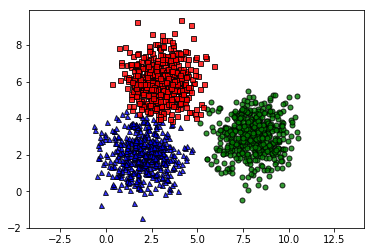

In [43]:
(centroids, labels, it) = kmeans(X, K)
print('Centers found by our algorithm:')
print(centroids[-1])

kmeans_display(X, labels[-1])

Từ kết quả này chúng ta thấy rằng thuật toán K-means Clustering làm việc khá thành công, các centroids tìm được khá gần với kỳ vọng ban đầu. Mặc dù màu sắc của hai nhóm xanh, đỏ đã bị hoán đổi nhưng những điểm ban đầu thuộc cùng một cluster gần như vẫn cùng thuộc một cluster.

### Kết quả tìm được bằng thư viện scikit-learn


Centers found by scikit-learn:
[[ 8.0410628   3.02094748]
 [ 2.99357611  6.03605255]
 [ 1.97634981  2.01123694]]


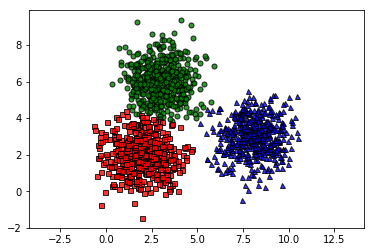

In [44]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print('Centers found by scikit-learn:')
print(kmeans.cluster_centers_)
pred_label = kmeans.predict(X)
kmeans_display(X, pred_label)

Chúng ta thấy rằng hai thuật toán khác nhau cho cùng một đáp số. Với cách thứ nhất, tôi mong muốn các bạn hiểu rõ được thuật toán. Với cách thứ hai, tôi hy vọng các bạn biết áp dụng thư viện sẵn có như thế nào.

# Hiển thị kết quả sau mỗi vòng lặp 

## Voronoi


In [46]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(centroids[-1])

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

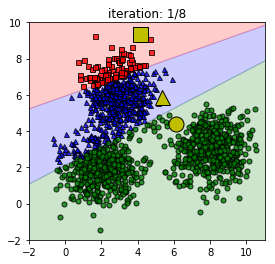

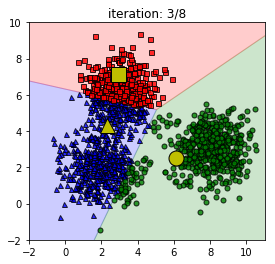

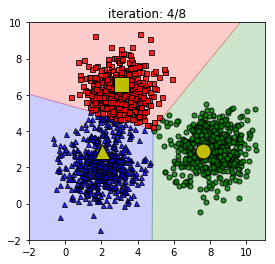

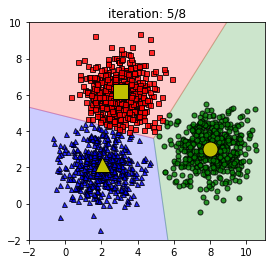

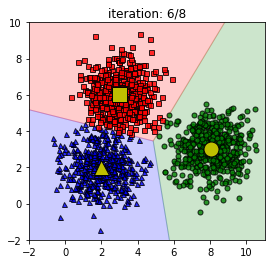

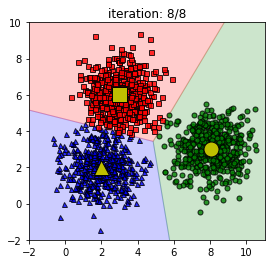

In [68]:
def kmeans_display_progress(X, centroids, labels, it):
    label = labels[it] # label at iteration it 
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    
    # draw data points with color 
    kwargs = {"markersize": 5, "alpha": .8, "markeredgecolor": 'k'}
    plt.plot(X0[:, 0], X0[:, 1], 'b^', **kwargs)
    plt.plot(X1[:, 0], X1[:, 1], 'go', **kwargs)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', **kwargs)
    
    # draw centroids 
    points = centroids[it]
    kwargs = {"markersize": 15, "markeredgecolor": 'k'}
    animlist = plt.plot(points[0, 0], points[0, 1], 'y^', **kwargs)
    animlist = plt.plot(points[1, 0], points[1, 1], 'yo', **kwargs)
    animlist = plt.plot(points[2, 0], points[2, 1], 'ys', **kwargs)
    
    # draw color for each voronoi region 
    colors = ['b', 'g', 'r']
    
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor, radius = 1000)
    for i,region in enumerate(regions):
        polygon = vertices[region]
        animlist = plt.fill(*zip(*polygon), alpha=.2, color = colors[i])
    plt.axis('scaled')
    plt.title('iteration: %d/%d' %(it+1, len(labels)))
    plt.axis([-2, 11, -2, 10])
    plt.show()
    
kmeans_display_progress(X, centroids, labels, 0)
kmeans_display_progress(X, centroids, labels, 2)
kmeans_display_progress(X, centroids, labels, 3)
kmeans_display_progress(X, centroids, labels, 4)
kmeans_display_progress(X, centroids, labels, 5)
kmeans_display_progress(X, centroids, labels, 7)